In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
retail = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)

In [4]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [5]:
retail.shape

(541909, 8)

In [6]:
retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Data Cleaning



In [7]:
#calculating the %age of missing values in the dataset
df_null = round(100*(retail.isnull().sum())/len(retail),2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [8]:
#Dropping rows having missing values
retail = retail.dropna()
retail.shape

(406829, 8)

In [9]:
#Changing the dtype of customerID from float to str
retail['CustomerID'] = retail['CustomerID'].astype(str)

In [10]:
#We want to achieve RFM-> Recency, Frequency, Monetary

In [11]:
#Creating new attribute: Monetary
retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfn_m = retail.groupby('CustomerID')['Amount'].sum()
rfn_m = rfn_m.reset_index()
rfn_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [12]:
#New Attribute: Frequency
rfn_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfn_f = rfn_f.reset_index()
rfn_f.columns = ['CustomerID','Frequency']
rfn_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [13]:
#Merging the 2 dfs
rfm = pd.merge(rfn_m, rfn_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [14]:
#New Attribute: Recency
#Convert to datetime to proper dtype
#Calculating the difference between the arrival of customer in 2 consecutive dates
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [15]:
retail['InvoiceDate']

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541904   2011-12-09 12:50:00
541905   2011-12-09 12:50:00
541906   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 406829, dtype: datetime64[ns]

In [16]:
#Compute the maximum/latest transaction date
max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [17]:
#Difference
retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [18]:
#Compute recency of customer
rfn_p = retail.groupby('CustomerID')['Diff'].min()
rfn_p = rfn_p.reset_index()
rfn_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [19]:
#No. of days
rfn_p['Diff'] = rfn_p['Diff'].dt.days
rfn_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [20]:
#Merge all dfs
rfm = pd.merge(rfm, rfn_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Text(0.5, 0, 'Attributes')

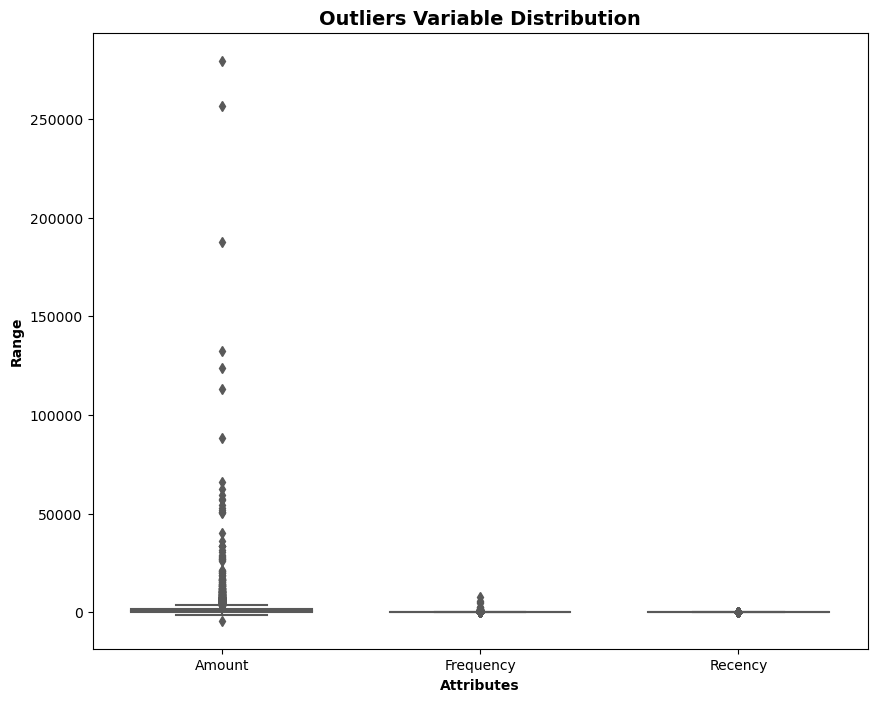

In [21]:
#Outlier Analysis of Amount Frequency and Recency
attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data= rfm[attributes], orient="v", palette="Set2", whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize=14, fontweight='bold')
plt.ylabel("Range", fontweight='bold')
plt.xlabel("Attributes", fontweight='bold')

In [24]:
#Eliminating outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3-Q1
rfm = rfm[(rfm.Amount >= Q1-1.5*IQR) & (rfm.Amount <= Q3+1.5*IQR)]

#Eliminating outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3-Q1
rfm = rfm[(rfm.Recency >= Q1-1.5*IQR) & (rfm.Recency <= Q3+1.5*IQR)]

#Eliminating outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3-Q1
rfm = rfm[(rfm.Frequency >= Q1-1.5*IQR) & (rfm.Frequency <= Q3+1.5*IQR)]

### Scaling the features

In [25]:
rfm_df = rfm[['Amount', 'Frequency', 'Recency']]
#Instantiate
scaler = StandardScaler()
#fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [26]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
#rfm_df_scaled
rfm_df_scaled.columns = ['Amount','Frequency','Recency']
#rfm_df_scaled_head()

### Model Building

In [27]:
#k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [28]:
kmeans.labels_

array([1, 0, 3, ..., 1, 3, 3])

In [29]:
set(kmeans.labels_)

{0, 1, 2, 3}

### Elbow Curve to get the right number of Clusters

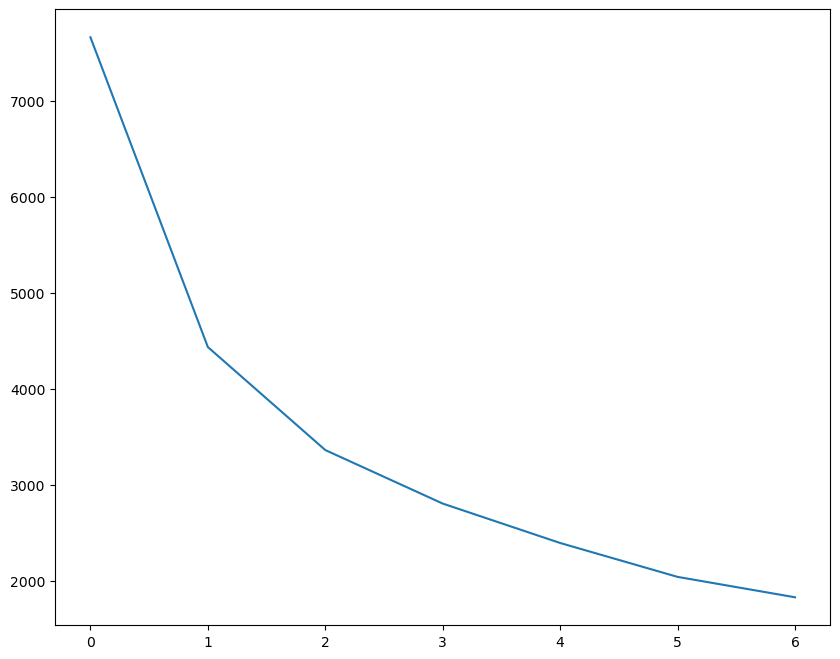

In [30]:
ssd = []
range_n_clusters = [2,3,4,5,6,7,8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters,max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
#inertia is the difference bw 2 points in same cluster
#plot the ssds for each n_clusters
plt.plot(ssd)

In [31]:
#Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=300)
kmeans.fit(rfm_df_scaled)

KMeans(n_clusters=3)

In [33]:
import pickle
#Define filename for pickle file
filename = 'kmeans_model.pkl'

#Open file in write mode
with open('kmeans_saved_model', 'wb') as file:
    #Save the kmeans model to the file
    pickle.dump(kmeans, file)
    
#Close the file
file.close()

pickle.dump(kmeans, open('kmeans_model.pkl','wb'))

In [34]:
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0])

In [35]:
kmeans.predict(rfm_df_scaled)

array([2, 1, 0, ..., 2, 0, 0])

In [36]:
#Assign the label
rfm['Cluster_Id'] = kmeans.predict(rfm_df_scaled)
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

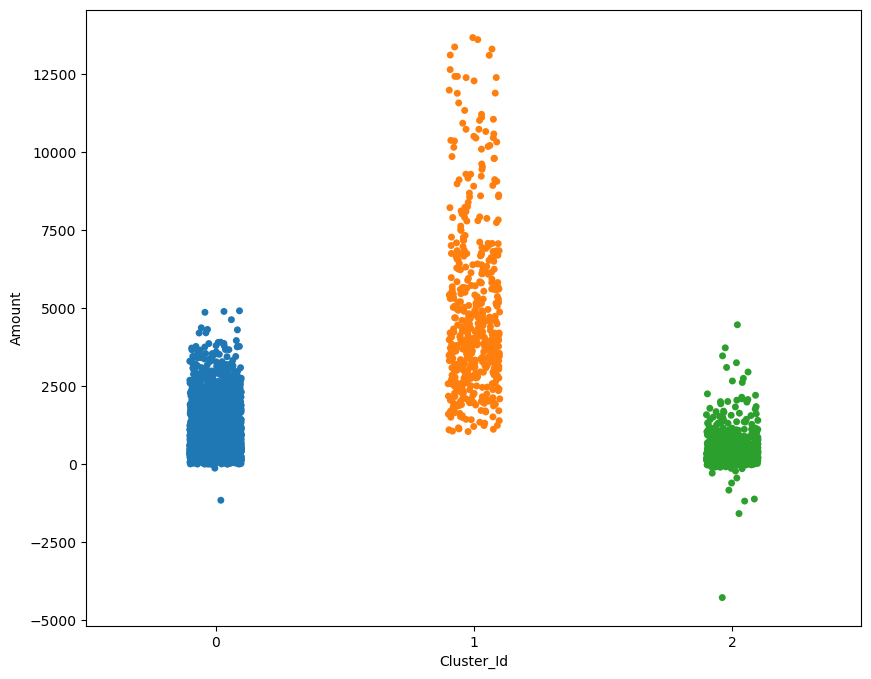

In [37]:
#Box plot to visualize cluster id vs amount
sns.stripplot(x='Cluster_Id', y='Amount', data=rfm)

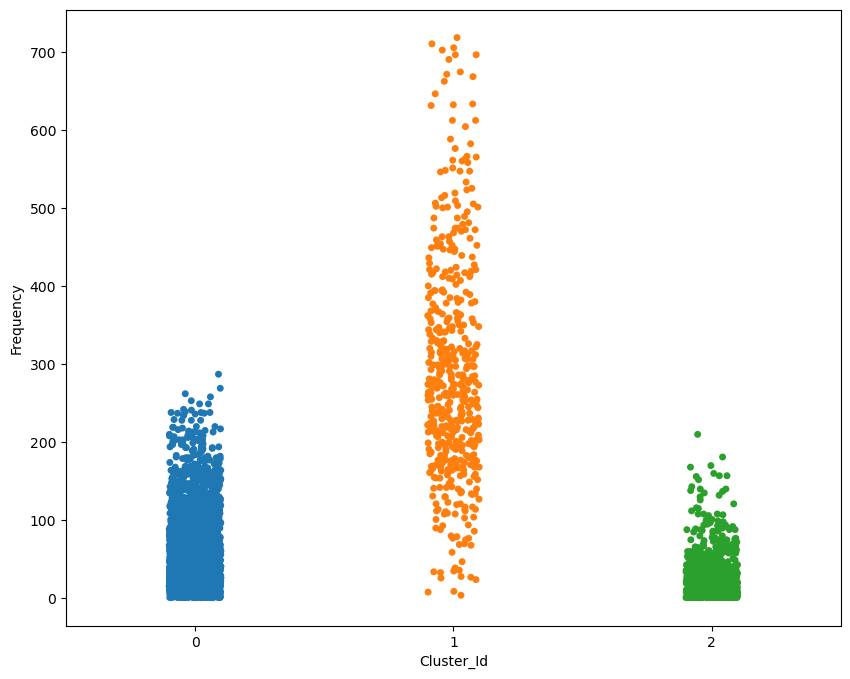

In [41]:
sns.stripplot(x='Cluster_Id', y='Frequency', data=rfm)
plt.savefig("stripplot.png")

### Thankyou